# Error Analysis Notebook

In [63]:

import sys
import os
import pandas as pd
import numpy as np

import constants as cons

from app.helper_functions import get_last_run_id

run_id = get_last_run_id()
analysis_df = pd.read_csv(f'./data/result_{run_id}/data_for_error_analysis.csv')
TARGET_COLUMNS = ['actual','predicted','incorrect','FP','FN']
FEATURE_COLUMNS = [col for col in analysis_df.columns if col not in TARGET_COLUMNS]


In [64]:
features = [x for x in FEATURE_COLUMNS if x not in cons.INDEX_COLUMNS]

feature_errors = {}

# Ensure 'actual' column is present in analysis_df
if 'actual' not in analysis_df.columns:
    raise KeyError("Column 'actual' not found in analysis_df")

for feature in features:
    
    grouped_df = analysis_df.groupby(feature)
    feature_errors[feature] = pd.concat([grouped_df[['actual','incorrect','FP','FN']].mean(), grouped_df.size().to_frame()], axis=1)
    feature_errors[feature].columns = ['actual','incorrect','FP','FN','count']
    feature_errors[feature].reset_index(inplace=True)  # Ensure 'level' column is present

long_errors_df = pd.concat(
    [df.assign(feature=feature) for feature, df in feature_errors.items()],
    ignore_index=True
)

# Rename the column corresponding to each feature to 'level'
for feature in features:
    long_errors_df.loc[long_errors_df['feature'] == feature, 'level'] = long_errors_df[feature]

# Drop the original feature columns
long_errors_df = long_errors_df.drop(columns=features)[['feature', 'level', 'actual','FP', 'FN', 'incorrect', 'count']]
long_errors_df['feature_level'] = long_errors_df['feature'].astype(str) + '_' + long_errors_df['level'].astype(str)


long_errors_df
    

#

,feature,level,actual,FP,FN,incorrect,count,feature_level
0,age_level,0.0,0.125000,0.500000,0.062500,0.562500,16,age_level_0.0
1,age_level,1.0,0.072849,0.383689,0.028153,0.411842,6891,age_level_1.0
2,age_level,2.0,0.070150,0.358562,0.031346,0.389908,22395,age_level_2.0
3,age_level,3.0,0.064187,0.291901,0.034704,0.326605,24522,age_level_3.0
4,age_level,4.0,0.061286,0.262035,0.037621,0.299656,9888,age_level_4.0
...,...,...,...,...,...,...,...,...
173,gender_Male,1.0,0.068188,0.331770,0.032823,0.364592,60964,gender_Male_1.0
174,var_1_0.0,0.0,0.072489,0.349157,0.033070,0.382226,28818,var_1_0.0_0.0
175,var_1_0.0,1.0,0.063974,0.301689,0.033488,0.335177,40313,var_1_0.0_1.0
176,var_1_1.0,0.0,0.063974,0.301689,0.033488,0.335177,40313,var_1_1.0_0.0


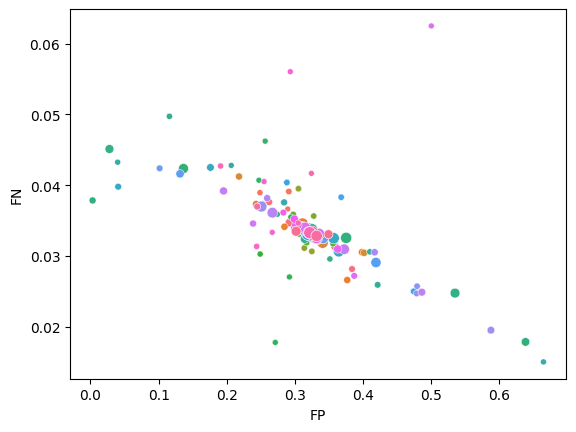

In [65]:

import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.scatterplot(data=long_errors_df, x='FP', y='FN', hue='feature_level', size='count', legend=False)
plt.show()

In [66]:
long_errors_df_sorted = long_errors_df.sort_values(by=['FP', 'FN', 'count'], ascending=[True, False,True])
long_errors_df_sorted.to_csv(f'./data/result_{run_id}/feature_error_analysis_sorted.csv', index=False)

In [67]:
total_FP = long_errors_df['FP'].mean()
total_FN = long_errors_df['FN'].mean()
total_incorrect = long_errors_df['incorrect'].mean()

print(f'FP={total_FP:.3f}, FN={total_FN:.3f}, Incorrect={total_incorrect:.3f}')

FP=0.318, FN=0.034, Incorrect=0.352


In [81]:
# Calculate the averages
avg_FP = long_errors_df['FP'].mean()
avg_FN = long_errors_df['FN'].mean()
avg_incorrect = long_errors_df['incorrect'].mean()
total_count = long_errors_df['count'].sum()

def compute_score(FP_diff, FN_diff, count, total_count):
    # a score that computes a censored weighted sum of the differences in FP, FN, and incorrect
    # if a measure is positive it is set to zero
    op=1
    FP_importance = 9
    FN_importance = 1
    eps = 1e-6

    if FP_diff > 0:
        FP_diff = 0
    if FN_diff > 0:
        FN_diff = 0
    if count < 1000:
        count_factor = 0
    else:
        count_factor = 1

    if op == 0:        
        return 1e6 * (count/total_count) * np.sqrt(FP_importance * FP_diff**2 + FN_importance * FN_diff**2)
    else:
        return 1e3 * count_factor * np.sqrt(FP_importance * FP_diff**2 + FN_importance * FN_diff**2)


# Compute the differences
long_errors_df_sorted['FP_diff'] = long_errors_df_sorted['FP'] - avg_FP
long_errors_df_sorted['FN_diff'] = long_errors_df_sorted['FN'] - avg_FN
long_errors_df_sorted['incorrect_diff'] = long_errors_df_sorted['incorrect'] - avg_incorrect
long_errors_df_sorted['score'] = long_errors_df_sorted.apply(
    lambda row: compute_score(row['FP_diff'], row['FN_diff'], row['count'], total_count), axis=1
)
long_errors_df_sorted.to_csv(f'./data/result_{run_id}/feature_error_analysis_diff2.csv', index=False)